In [35]:
import sys
sys.path.append('/Users/evatakou/noise_est')
import stim
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt
from pymatching import Matching
import matplotlib

In [36]:
from sims.repetition_code_Steane_SE.four_point_method import *
from sims.repetition_code_Steane_SE.rep_code_Steane_circuit import *
from utilities.utils_for_decoding import *
from utilities.general_utils import *
from sims.repetition_code_Steane_SE.utilities_for_Steane_SE import *
from sims.repetition_code_Steane_SE.construct_dem import *

In [39]:
def estimate_edges(num_shots_est,distance,num_rounds,circuit):

    p_depol_after_for_4cnts = [] #Do not make any assumption that we know this value
    defects_matrix          = get_defects_matrix(distance,num_rounds,num_shots_est,circuit)
    vi_mean                 = avg_vi(defects_matrix)
    vivj_mean               = avg_vivj(defects_matrix.data)
    p4_cnts                 = get_4_pnt_events(defects_matrix.data,p_depol_after_for_4cnts)
    
    
    num_ancilla = distance-1


    det_inds_rd_anc = get_det_inds_as_rd_anc_pairs(num_rounds,num_ancilla)
    vijkl           = get_vijkl(p4_cnts,num_rounds,num_ancilla,vi_mean,vivj_mean,det_inds_rd_anc)

    min_bound = 1e-6
    max_bound = 0.8
    method    = "least_squares" 
    all_dicts = solve_system_of_equations(min_bound,max_bound,method,vijkl)    


    bulk_edges,time_edges,bd_edges   = edge_dicts(num_ancilla,num_rounds)
    pij_bulk,pij_time,pij_bd,p4_cnts = fill_initial_prob_values(all_dicts,bulk_edges,time_edges)


    pij_bulk, pij_time, pij_bd, p4_cnts = update_edges_after_4_pnt_estimation(pij_bulk,pij_time,pij_bd,p4_cnts,num_rounds,vi_mean,distance)

    
    return pij_bulk,pij_time,pij_bd,p4_cnts




matplotlib.rcParams.update({'font.size': 17})
plt.rcParams["font.family"] = "Microsoft Sans Serif"


For L=3
stim: [0.00103, 0.0028176, 0.0107462, 0.0386744, 0.0995488, 0.1687196]
mine: [0.0010986, 0.0029124, 0.0112898, 0.0402986, 0.0994538, 0.1693522]
---
For L=5
stim: [0.0001272, 0.0005626, 0.004414, 0.0296514, 0.1127072, 0.2184814]
mine: [0.0001162, 0.0005598, 0.0043352, 0.0288556, 0.1123894, 0.217192]
---
For L=7
stim: [1.18e-05, 9.74e-05, 0.0014968, 0.0206022, 0.1169326, 0.256036]
mine: [9.4e-06, 9.12e-05, 0.0013838, 0.0191692, 0.1153698, 0.2534766]
---
For L=9
stim: [1e-06, 1.5e-05, 0.0004918, 0.0139496, 0.1193274, 0.2873958]
mine: [1e-06, 1.3e-05, 0.0004388, 0.0132232, 0.1167072, 0.284478]
---


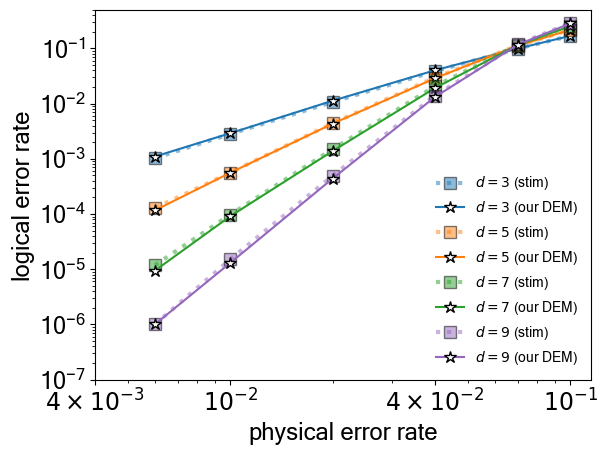

In [40]:
#W/ Parallel processing
import matplotlib.pyplot as plt
import matplotlib
from joblib import Parallel, delayed

def logical_error(num_shots_est, num_shots):
    
    Ls = [3,5,7,9] 
    ps = [6e-3, 0.01, 0.02, 0.04, 0.07, 0.1]

    fig, ax = plt.subplots()
    matplotlib.rcParams.update({'font.size': 17})
    plt.rcParams["font.family"] = "Microsoft Sans Serif"

    Reset = True
    after_CNOT_depol_type = 'DEPOLARIZE2'
    logical_state = '0'

    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:purple', 'tab:cyan']
    cnt = 0

    all_errors_stim = []
    all_errors_our  = []

    def run_for_p(L, p):
        p_data = p
        p_anc = p
        p_depol_after = p

        circuit = repetition_code_circuit_Steane_Extraction(L, L,
                                                            p_data, p_anc, Reset, p_depol_after,
                                                            after_CNOT_depol_type, logical_state)

        pij_bulk, pij_time, pij_bd, p4_cnts = estimate_edges(num_shots_est, L, L, circuit)
        my_DEM = construct_dem(pij_bulk, pij_bd, pij_time, p4_cnts)
        my_LE, stims_LE = decode_both_dems_same_data(my_DEM, circuit, num_shots)

        return stims_LE / num_shots, my_LE / num_shots

    for L in Ls:
        results = Parallel(n_jobs=-1)(delayed(run_for_p)(L, p) for p in ps)

        error_per_p_Stim = [r[0] for r in results]
        error_per_p_my_DEM = [r[1] for r in results]

        print(f"For L={L}")
        print("stim:", error_per_p_Stim)
        print("mine:", error_per_p_my_DEM)
        print("---")

        plt.semilogy(ps, error_per_p_Stim, marker='s', linestyle=':', color=colors[cnt],
                     linewidth=3, markeredgecolor='black',
                     markersize=9, alpha=0.5)
        plt.semilogy(ps, error_per_p_my_DEM, marker='*', color=colors[cnt],
                     markersize=9, markeredgecolor='black', markerfacecolor='white')
        cnt += 1

        all_errors_stim.append(error_per_p_Stim)
        all_errors_our.append(error_per_p_my_DEM)

    plt.legend(["$d=3$ (stim)", "$d=3$ (our DEM)",
                "$d=5$ (stim)", "$d=5$ (our DEM)",
                "$d=7$ (stim)", "$d=7$ (our DEM)",
                "$d=9$ (stim)", "$d=9$ (our DEM)",
                "$d=11$ (stim)", "$d=11$ (our DEM)"],
               frameon=False, shadow=True, fontsize=10)

    plt.xscale('log')
    plt.xticks(ticks=[4 * 10 ** -3, 0.01, 4 * 0.01, 0.1], labels=[r'$4 \times 10^{-3}$', '$10^{-2}$',
                                                                  r'$4\times 10^{-2}$', '$10^{-1}$'])
    plt.xlabel('physical error rate')
    plt.ylabel('logical error rate')
    plt.ylim([1e-7, 5e-1])
    plt.show()

    #uncomment to save the figure
    # fig.savefig("threshold_new.pdf",bbox_inches='tight')

    return ps, Ls, all_errors_stim, all_errors_our


num_shots_est                        = 5*10**6 #5*10**6 for both
num_shots                            = 5*10**6
ps,Ls,all_errors_stim,all_errors_our = logical_error(num_shots_est,num_shots)

In [12]:
#To save the data

with open("stims_LE_threshold_new.txt", "w") as file:
    file.write(str(all_errors_stim))
with open("all_errors_my_DEM_new.txt", "w") as file:
    file.write(str(all_errors_our))    
with open("ps_threshold_new.txt", "w") as file:
    file.write(str(ps))   
with open("Ls_threshold_new.txt", "w") as file:
    file.write(str(Ls))   